In [1]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd

In [2]:
#Seven-Day Load Forecast by Weather Zone URL
url = 'http://mis.ercot.com/misapp/GetReports.do?reportTypeId=12312&reportTitle=Seven-Day%20Load%20Forecast%20by%20Weather%20Zone&showHTMLView=&mimicKey'

In [3]:
response = requests.get(url)

In [4]:
soup = bs(response.text, 'html.parser')

In [5]:
title_results = soup.find_all('td', class_='labelOptional_ind')

In [6]:
for result in title_results:
    print(result.text)

cdr.00012312.0000000000000000.20200725.233001109.LFCWEATHERNP3561_csv.zip
cdr.00012312.0000000000000000.20200725.233001023.LFCWEATHERNP3561_xml.zip
cdr.00012312.0000000000000000.20200725.223000990.LFCWEATHERNP3561_csv.zip
cdr.00012312.0000000000000000.20200725.223000855.LFCWEATHERNP3561_xml.zip
cdr.00012312.0000000000000000.20200725.213003091.LFCWEATHERNP3561_csv.zip
cdr.00012312.0000000000000000.20200725.213003008.LFCWEATHERNP3561_xml.zip
cdr.00012312.0000000000000000.20200725.203001056.LFCWEATHERNP3561_csv.zip
cdr.00012312.0000000000000000.20200725.203000931.LFCWEATHERNP3561_xml.zip
cdr.00012312.0000000000000000.20200725.193000815.LFCWEATHERNP3561_csv.zip
cdr.00012312.0000000000000000.20200725.193000748.LFCWEATHERNP3561_xml.zip
cdr.00012312.0000000000000000.20200725.183000584.LFCWEATHERNP3561_csv.zip
cdr.00012312.0000000000000000.20200725.183000508.LFCWEATHERNP3561_xml.zip
cdr.00012312.0000000000000000.20200725.173002318.LFCWEATHERNP3561_csv.zip
cdr.00012312.0000000000000000.20200725

In [7]:
url_results = soup.find_all('td', class_='labelOptional', text=True)

In [8]:
base_url = 'http://mis.ercot.com'

data_urls = []

for result in url_results:
    try:
        end_url = result.find('div').a['href']
        full_url = base_url + end_url
        data_urls.append(full_url)
        #print(full_url)
    except:
        pass

## Visit URL

In [9]:
data = requests.get(data_urls[0], stream=True)

In [10]:
import requests, zipfile, io

In [11]:
z = zipfile.ZipFile(io.BytesIO(data.content))

In [12]:
z.extractall()

In [13]:
file = z.namelist()[0]

In [14]:
load_fcst = pd.read_csv(file)

In [15]:
load_fcst

,DeliveryDate,HourEnding,Coast,East,FarWest,North,NorthCentral,SouthCentral,Southern,West,SystemTotal,DSTFlag
0,07/25/2020,1:00,12911.0996,1788.4301,3915.1299,1063.8101,15900.7002,8495.8701,4015.9900,1633.4100,49724.4400,N
1,07/25/2020,2:00,12480.7998,1643.0800,3838.8899,1018.4600,14940.5996,7909.5098,3782.8899,1483.2300,47097.4590,N
2,07/25/2020,3:00,12031.5000,1589.1400,3795.8301,981.7140,14000.2002,7495.5498,3569.3799,1388.6801,44851.9941,N
3,07/25/2020,4:00,11798.2998,1557.9200,3735.1499,963.5380,13179.0000,6999.5298,3439.4399,1406.2400,43079.1174,N
4,07/25/2020,5:00,11677.5000,1506.8199,3679.6299,910.7460,12853.5000,6765.1899,3436.1899,1275.6801,42105.2557,N
...,...,...,...,...,...,...,...,...,...,...,...,...
187,08/01/2020,20:00,15862.5000,2173.9600,4256.5200,1383.8900,20614.9004,10854.2002,4844.9102,2004.7100,61995.5908,N
188,08/01/2020,21:00,15949.0000,2117.3000,4226.3901,1353.7500,19982.5000,10489.7998,4751.5898,1962.1600,60832.4897,N
189,08/01/2020,22:00,15537.5000,2071.8401,4214.9302,1303.0200,19329.8008,10049.2002,4698.1499,1907.9900,59112.4312,N
190,08/01/2020,23:00,14775.2002,1933.0601,4083.2000,1209.8300,18012.5000,9414.3604,4476.1299,1803.2200,55707.5006,N


In [16]:
#clean existing columns
load_fcst['DeliveryDate'] = pd.to_datetime(load_fcst.DeliveryDate)
load_fcst['HourEnding'] = load_fcst.HourEnding.str.split(':').str[0]

#add file name and process info to df
load_fcst['FileName'] = z.namelist()[0]
load_fcst['ProcessDate'] = pd.to_datetime(load_fcst.FileName.str.split('.').str[3])
load_fcst['ProcessHour'] = load_fcst.FileName.str.split('.').str[4]
load_fcst['DT'] = pd.to_datetime(load_fcst.FileName.str.split('.').str[3] + load_fcst.FileName.str.split('.').str[4])


In [17]:
load_fcst['DeliveryDT'] = pd.to_datetime(load_fcst.DeliveryDate) + load_fcst.HourEnding.astype('timedelta64[h]')

In [18]:
load_fcst.head()

,DeliveryDate,HourEnding,Coast,East,FarWest,North,NorthCentral,SouthCentral,Southern,West,SystemTotal,DSTFlag,FileName,ProcessDate,ProcessHour,DT,DeliveryDT
0,2020-07-25,1,12911.0996,1788.4301,3915.1299,1063.8101,15900.7002,8495.8701,4015.9900,1633.4100,49724.4400,N,cdr.00012312.0000000000000000.20200725.233000....,2020-07-25,233000,2020-07-25 23:30:00,2020-07-25 01:00:00
1,2020-07-25,2,12480.7998,1643.0800,3838.8899,1018.4600,14940.5996,7909.5098,3782.8899,1483.2300,47097.4590,N,cdr.00012312.0000000000000000.20200725.233000....,2020-07-25,233000,2020-07-25 23:30:00,2020-07-25 02:00:00
2,2020-07-25,3,12031.5000,1589.1400,3795.8301,981.7140,14000.2002,7495.5498,3569.3799,1388.6801,44851.9941,N,cdr.00012312.0000000000000000.20200725.233000....,2020-07-25,233000,2020-07-25 23:30:00,2020-07-25 03:00:00
3,2020-07-25,4,11798.2998,1557.9200,3735.1499,963.5380,13179.0000,6999.5298,3439.4399,1406.2400,43079.1174,N,cdr.00012312.0000000000000000.20200725.233000....,2020-07-25,233000,2020-07-25 23:30:00,2020-07-25 04:00:00
4,2020-07-25,5,11677.5000,1506.8199,3679.6299,910.7460,12853.5000,6765.1899,3436.1899,1275.6801,42105.2557,N,cdr.00012312.0000000000000000.20200725.233000....,2020-07-25,233000,2020-07-25 23:30:00,2020-07-25 05:00:00


In [19]:
load_fcst.describe()

,Coast,East,FarWest,North,NorthCentral,SouthCentral,Southern,West,SystemTotal
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,13989.468724,1869.242499,3984.348327,1151.668144,16789.393229,8330.752849,3873.982286,1649.844846,51638.700905
std,1961.631511,309.349402,204.093519,203.255152,3191.023814,1523.477977,652.257706,232.170259,8068.935379
min,10620.500000,1351.120000,3631.590100,833.460000,11676.200200,5726.830100,2752.240000,1194.310100,38125.326200
25%,12199.599850,1587.862500,3784.530000,961.244500,13709.149900,6965.672600,3394.337500,1453.845000,44057.317725
50%,13873.549800,1879.135000,3977.270050,1147.929950,16585.899400,8309.085450,3769.845000,1607.295050,51566.395100
75%,15731.174800,2161.742525,4175.397325,1313.100000,19547.974600,9606.444825,4255.622300,1844.645000,58332.449900
max,17738.400400,2399.080100,4355.000000,1557.560100,23074.900400,11318.000000,5333.080100,2096.889900,67583.420700


In [20]:
load_fcst.dtypes

DeliveryDate    datetime64[ns]
HourEnding              object
Coast                  float64
East                   float64
FarWest                float64
North                  float64
NorthCentral           float64
SouthCentral           float64
Southern               float64
West                   float64
SystemTotal            float64
DSTFlag                 object
FileName                object
ProcessDate     datetime64[ns]
ProcessHour             object
DT              datetime64[ns]
DeliveryDT      datetime64[ns]
dtype: object

In [21]:
z.namelist()[0]

'cdr.00012312.0000000000000000.20200725.233000.LFCWEATHERNP3561.csv'

### Convert DF to Long Format (i.e. Unpivot Forecast columns)

In [22]:
#long_load_fcst = pd.melt(load_fcst, id_vars=['Coast','East','FarWest','North','NorthCentral','SouthCentral','Southern','West','SystemTotal'],var_name='WeatherZone', value_name ='MW')
#long_load_fcst = pd.melt(load_fcst, id_vars='DeliveryDT',var_name='WeatherZone', value_name ='MW')
testdf = load_fcst.stack()

testdf

0    DeliveryDate                                  2020-07-25 00:00:00
     HourEnding                                                      1
     Coast                                                     12911.1
     East                                                      1788.43
     FarWest                                                   3915.13
                                           ...                        
191  FileName        cdr.00012312.0000000000000000.20200725.233000....
     ProcessDate                                   2020-07-25 00:00:00
     ProcessHour                                                233000
     DT                                            2020-07-25 23:30:00
     DeliveryDT                                    2020-08-02 00:00:00
Length: 3264, dtype: object

In [ ]:
long_load_fcst.head()

## Plotting Forecasts

In [31]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"

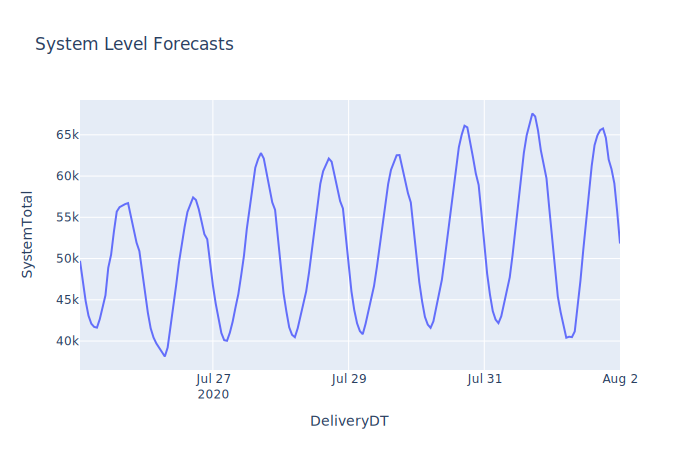

In [32]:
fig = px.line(load_fcst, x="DeliveryDT", y="SystemTotal", title='System Level Forecasts')
fig.show()

In [33]:
fcst_list = [load_fcst.Coast, load_fcst.East, load_fcst.FarWest, load_fcst.North, load_fcst.NorthCentral, load_fcst.SouthCentral, load_fcst.Southern, load_fcst.West]

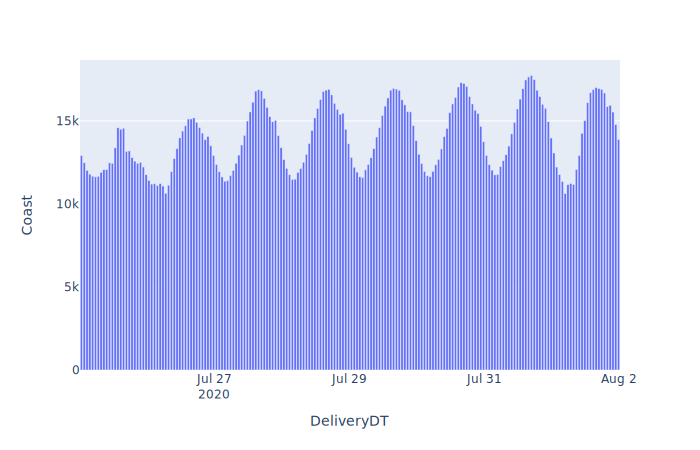

In [34]:
barfig = px.bar(load_fcst, x='DeliveryDT', y=load_fcst.Coast)
barfig.show('svg')